In [1]:
# Map problem to circuits and operators (https://www.nature.com/articles/s41586-023-06096-3 -> Evidence for the utility of quantum computing before fault tolerance)

In [2]:
# Transvers field Ising model to demo primitives

In [17]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import YGate, UnitaryGate
import numpy as np

SYGate = UnitaryGate(YGate().power(1/2), label=r"$\sqrt{Y}$")
SYdgGate = UnitaryGate(SYGate.inverse() , label=r"$\sqrt{Y}^\dag$")

def generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, num_cl_bits = 0, trotter_barriers = False, layer_barriers = False):
    if num_cl_bits == 0:
        qc = QuantumCircuit(num_qubits)
    else:
        qc = QuantumCircuit(num_qubits, num_cl_bits)

    for trotter_step in range(num_trotter_steps):
        add_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers)
        if trotter_barriers:
            qc.barrier()

    return qc


def add_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers = False):
    # adding Rzz in the even layers
    for i in range(0, qc.num_qubits-1, 2):
        qc.sdg([i, i+1])
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
    if layer_barriers:
        qc.barrier()

    # adding Rzz in the odd layers
    for i in range(1, qc.num_qubits-1, 2):
        qc.sdg([i, i+1])
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
    if layer_barriers:
        qc.barrier()

    qc.rx(rx_angle, list(range(qc.num_qubits)))

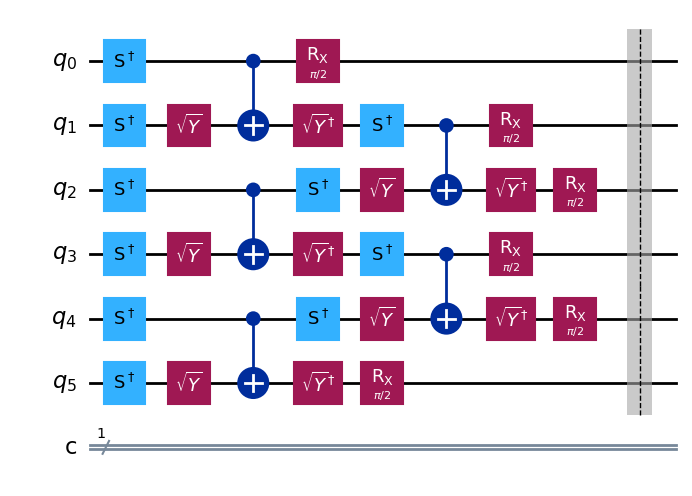

In [4]:
num_qubits = 6
num_trotter_steps = 1
rx_angle = 0.5 * np.pi

qc = generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, True, True)
qc.draw(output='mpl', fold=-1)

In [5]:
# Demo: Sampler

In [6]:
def append_mirrored_1d_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers = False, layer_barriers = False):
    for trotter_step in range(num_trotter_steps):
        add_mirrored_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers)
        if trotter_barriers:
            qc.barrier()


def add_mirrored_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers = False):
    qc.rx(-rx_angle, list(range(qc.num_qubits)))
    if layer_barriers:
        qc.barrier()

        # adding Rzz in the odd layers
    for i in range(1, qc.num_qubits-1, 2):
        qc.append(SYGate, [i+1])        
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
        qc.s([i, i+1])
    if layer_barriers:
        qc.barrier()

    # adding Rzz in the even layers
    for i in range(0, qc.num_qubits-1, 2):
        qc.append(SYGate, [i+1])        
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
        qc.s([i, i+1])

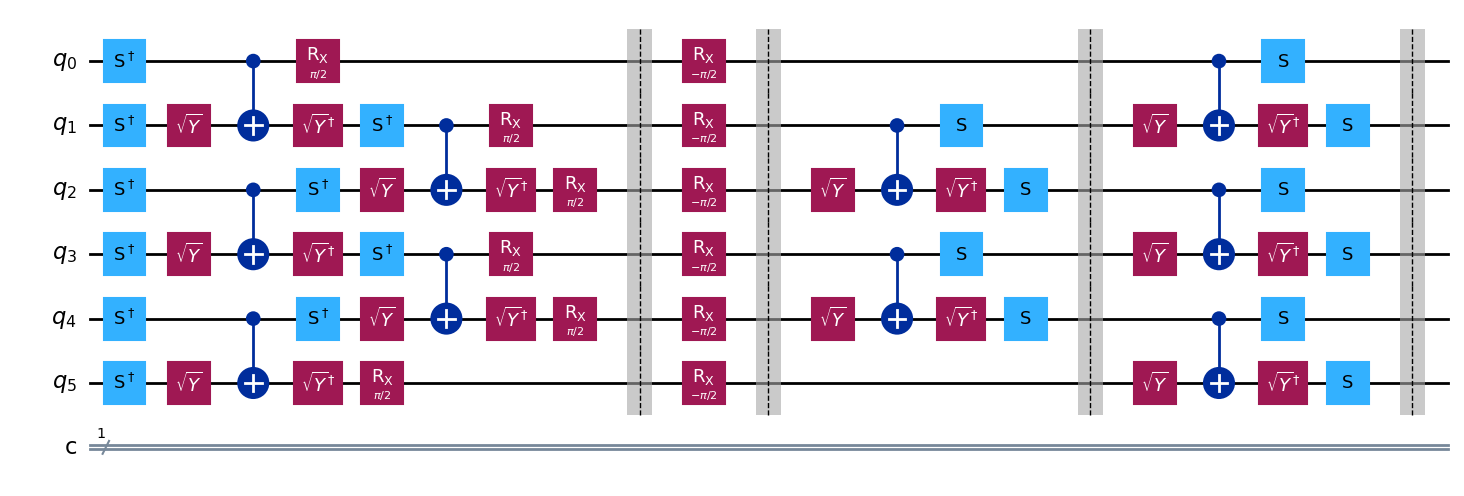

In [7]:
append_mirrored_1d_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, True, True)
qc.draw(output='mpl', fold=-1)

In [8]:
# Map the problem to circuits and observables

In [9]:
max_trotter_steps = 10
num_qubits = 100
measured_qubits = [49, 50]

qc_list = []
for trotter_step in range(max_trotter_steps):
    qc = generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, len(measured_qubits), True, True)
    append_mirrored_1d_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, True, True)
    qc.measure(measured_qubits, list(range(len(measured_qubits))))
    qc_list.append(qc)

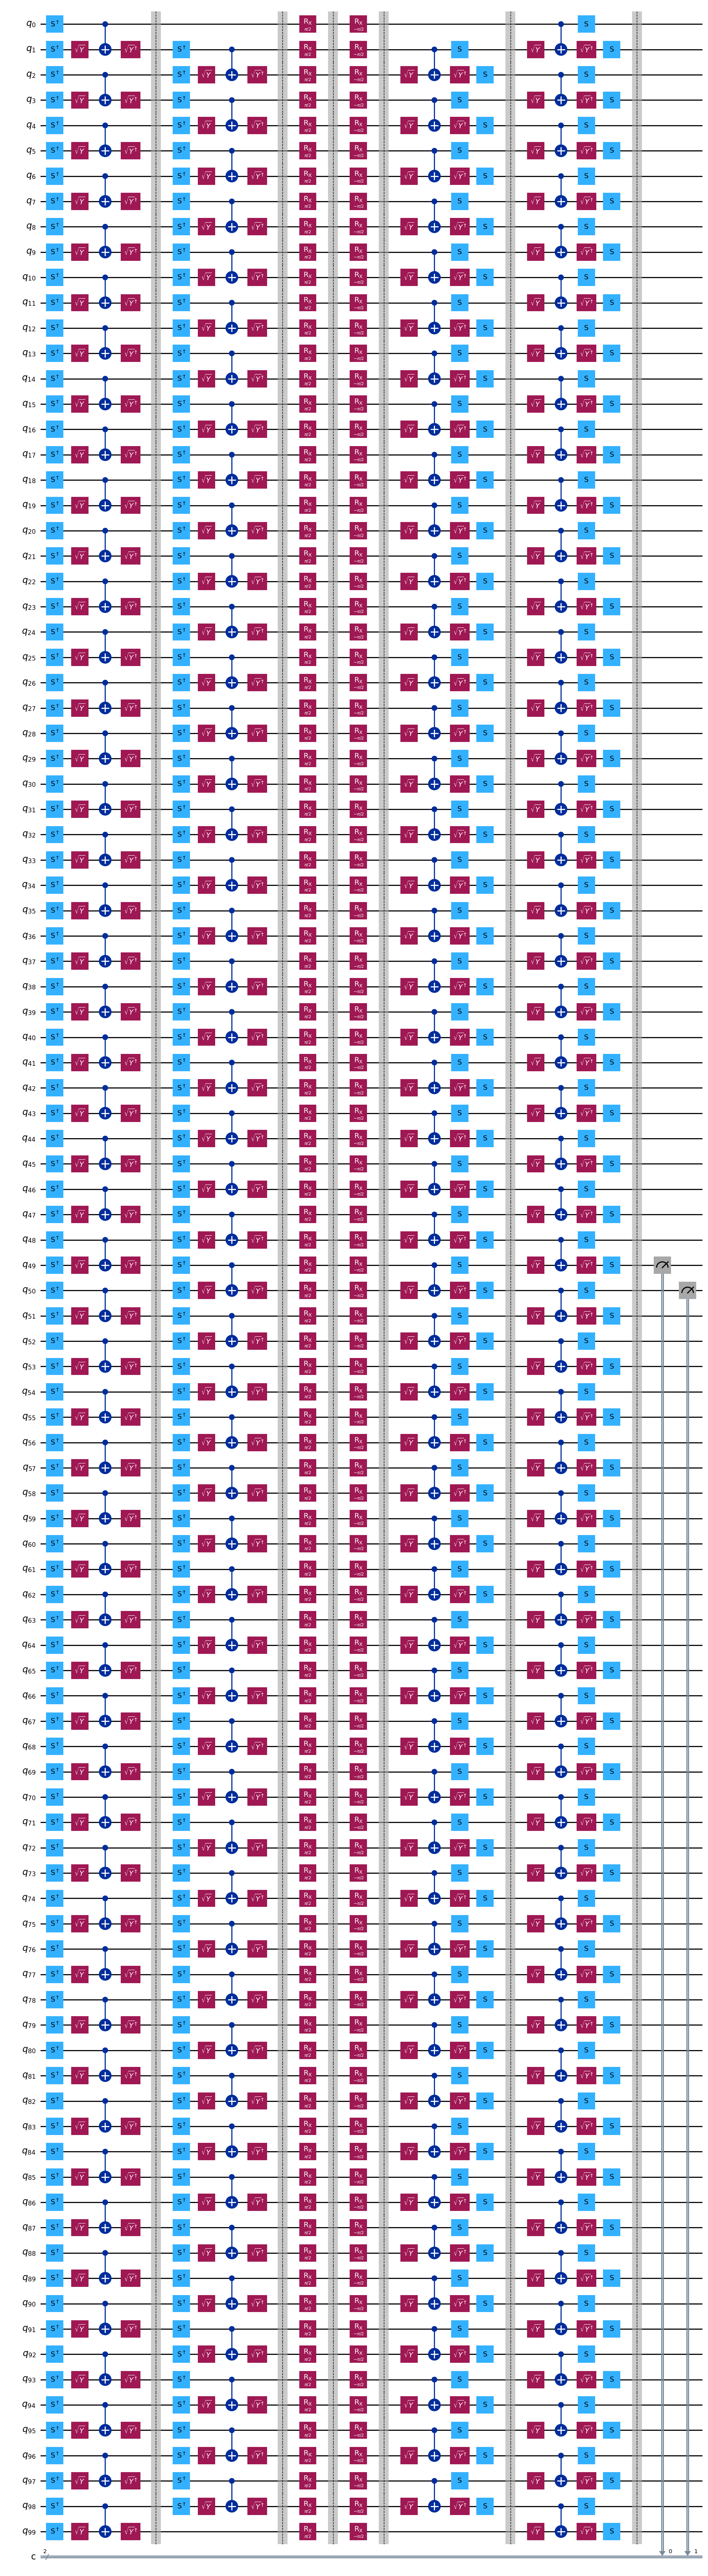

In [10]:
qc_list[1].draw(output='mpl', fold=-1)

In [11]:
# Optimize

In [12]:
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService

backend_name = "ibm_brisbane"
service = QiskitRuntimeService()
backend = service.backend(backend_name)
print("Done getting the backend")

qc_transpiled_list = transpile(qc_list, backend, optimization_level=1)

KeyboardInterrupt: 

In [ ]:
# Execute on hardware

In [ ]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(backend)
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"

job = sampler.run(qc_transpiled_list)
print(job.job_id())

In [ ]:
# Postprocessing and plotting

In [28]:
job_id = "cxz70zk3wrp0008m5360"
job = service.job(job_id)

survival_probability_list = []
for trotter_step in range(max_trotter_steps):
    try:
        data = job.result()[trotter_step].data
        survival_probability_list.append(data.c.get_counts()['0' * len(measured_qubits)]/data.c.num_shots)
    except:
        survival_probability_list.append(0)

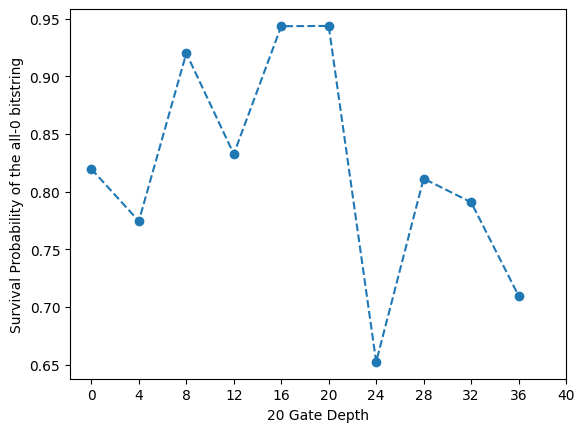

In [29]:
import matplotlib.pyplot as plt

plt.plot(list(range(0, 4 * max_trotter_steps, 4)), survival_probability_list, '--o')
plt.xlabel('20 Gate Depth')
plt.ylabel('Survival Probability of the all-0 bitstring')
plt.xticks(np.arange(0, 44, 4))
plt.show()

In [ ]:
# Estimator

In [ ]:
# Mapping the Problem

In [18]:
from qiskit.circuit import Parameter

rx_angle = Parameter("rx_angle")
trotter_steps = 2
qc = generate_1d_tfim_circuit(num_qubits, trotter_steps, rx_angle)

from qiskit.quantum_info import SparsePauliOp

middle_index = num_qubits // 2
observable = SparsePauliOp("I" * middle_index + "Z" + "I" * (middle_index-1))

In [19]:
# Optimize the Circuit

In [20]:
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService

backend_name = 'ibm_brisbane'
service = QiskitRuntimeService()
backend = service.backend(backend_name)

qc_transpiled = transpile(qc, backend=backend, optimization_level=1)
observable = observable.apply_layout(qc_transpiled.layout)

In [21]:
# Execute on Hardware

In [24]:
from qiskit_ibm_runtime import EstimatorV2, EstimatorOptions

min_rx_angle = 0
max_rx_angle = np.pi/2
num_rx_angle = 12
rx_angle_list = np.linspace(min_rx_angle, max_rx_angle, num_rx_angle)

options = EstimatorOptions()
options.resilience_level = 1
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XY4"

estimator = EstimatorV2(backend, options)
job = estimator.run([(qc_transpiled, observable, rx_angle_list)])
print(job.job_id())

C:\Users\A200134741\OneDrive\Practice\Quantum\environment\Lib\site-packages\qiskit_ibm_runtime\qiskit_runtime_service.py:836: UserWarning: The backend ibm_brisbane currently has a status of internal.
  warnings.warn(


<bound method BasePrimitiveJob.job_id of <RuntimeJobV2('cxz7t7ry1ae0008nhpb0', 'estimator')>>


In [25]:
# Postprocessing and Plotting

(-0.1, 0.1)

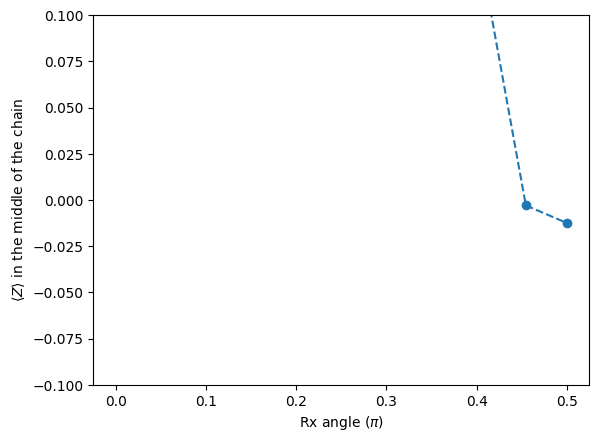

In [30]:
job_id = "cxz7t7ry1ae0008nhpb0"
job = service.job(job_id)

exp_val_list = job.result()[0].data.evs

plt.plot(rx_angle_list / np.pi, exp_val_list, '--o')
plt.xlabel(r'Rx angle ($\pi$)')
plt.ylabel(r'$\langle Z \rangle$ in the middle of the chain')
plt.ylim(-0.1, 0.1)